<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Numerical Integration</h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.31</h2>
</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/08_Numerical_Integration.ipynb)

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Preliminary functions](#config)
* [Riemann Sums](#sr)
* [Midpoint Rule](#mp)
* [Trapezoid Rule](#rt)
* [Simpson's Rule](#rs)
* [Gaussian Quadrature](#cg)
* [Convergence Analysis](#ca)
* [Time Analysis](#ta)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import time
%matplotlib inline
from ipywidgets import interact
import inspect
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from scipy.interpolate import BarycentricInterpolator
from scipy import integrate
import pandas as pd
from IPython.display import display

<div id='intro' />

# Introduction
[Back to TOC](#toc)

In this jupyter notebook we will study different numerical methods to integrate a function numerically.
Here we mention a few reasons of why we may need to numerically integrate a function:
- The computation of the anti-derivative may be too expensive. One could usually use a package for symbolic computation as `SymPy`, and it would be a good alternative, but it may be a bit slow for certain applications. Anyhow, it is recommended to try it out.
- We may face the need to obtain the integral of a function that does not have an anti-derivative, such as $\frac{\sin(x)}{x}$ or $\exp(-x^2)$, for instance.

Thus, it is quite useful to be able to compute derivatives of a function! For instance, as we mentioned before, there does not exist the anti-derivative for some functions, however we may be able to build it numerically!

<div id='config' />

# Preliminary functions
[Back to TOC](#toc)

The next function will allow to visualize a graphical interpretation of the different algorithms we will study, which may be useful, but the heart of this is the algebraic understanding.

In [2]:
###########################################################################
# General plotting framework
###########################################################################
def plot(f, xbin, ybin, int_val, m, text, a, b, xi, figname='', type_quadrature='close', save_file=False):
    plt.figure(figsize=(12,6))
    n = 201
    # Get a representation of f as a continuous function
    x = np.linspace(xbin.min(), xbin.max(), n)
    y = f(x)
    # Plot the function
    plt.plot(x, y, 'r', lw=2.0)
    plt.plot(xi, f(xi), 'b.', lw=2.0) 
    plt.grid(True)
    # Plot the interpolation
    plt.fill_between(xbin, 0, ybin, alpha=0.25, lw=2.0)
    # Setting the lims
    ymin, ymax = y.min(), y.max()
    if abs(ymax-ymin)<1E-6:
        ymin, ymax = 0.0, 1.0
    dy = .1*(ymax-ymin)
    plt.ylim([ymin-dy,ymax+dy])
    xmin, xmax = x.min(), x.max()
    if abs(b-a)<1e-6:
        xmin, xmax = 0.0, 1.0
    dx = .1*(b-a)
    plt.xlim([xmin-dx,xmax+dx])
    # Do the text
    if m>1:
        if type_quadrature=='close':
            text_image = r"$%s \approx %.10f$ (using %d eval.)" %(text, int_val, m+1)
        else:
            text_image = r"$%s \approx %.10f$ (using %d eval.)" %(text, int_val, m)
        plt.text(min(x), max(y), text_image, fontsize=18)
    plt.xlabel("x")
    plt.ylabel("y")
    if save_file:
        plt.savefig(figname)
        plt.close()
    else:
        plt.show()
    return

### Some parameters

For the initial numerical experiments, we will consider the function we will integrate is $f(x)$ defined on the domain $[a,b]$. An we will consider that we will integrate numerically the function $f(x)$ with $m$ intervals on the domain $[a,b]$.

In [3]:
#limits of integration
a = -1; b = 1
#function to integrate
myfun = lambda x : np.exp(x)
#text to show in the graphs
# int_exact = integrate.quad(myfun,-1,1,epsabs=1e-12, epsrel=1e-12)[0]
int_exact=np.exp(1)-np.exp(-1) # We know it, so we use it!
text= r"\int_{%+.2f}^{%+.2f} \exp(x) dx = %.10f" %(a,b,int_exact)

<div id='sr' />

# Riemann's Sums
[Back to TOC](#toc)

As a first numerical approximation of an definite integral we have the Riemann sum, this theory goes beyond of this course but it may be interesting to take a look to it!
What we will discuss here are the two well known Riemann sum, the left and the right version.
They way they work is to approximate the integral as a weighted sum, where the weight is defined different from the left and the right version.
In both cases the integration domain $[a,b]$ is divided in intervals, bot necessarily equalspaced but we will consider them as equalspaced for simplicity.
This means $a = x_0 < x_1 < \cdots < x_{m-1} < x_m = b$ and, as we mentioned before, we have $h=x_{k+1}-x_{k}$.

## Left Riemann sum
This alternative approximate the integral on the interval $[x_k,x_{k+1}]$ as $f(x_{k})\,h$, thus, its composite version is as follows,
\begin{align*}
c = \int_a^b f(x) dx & \approx \sum_{k=0}^{m-1} f(x_{k})\,h
\end{align*}

## Right Riemann sum
On the other hand, this alternative approximate the integral on the interval $[x_{k},x_{k+1}]$ as $f(x_{k+1})\,h$, thus, its composite version is as follows,
\begin{align*}
c = \int_a^b f(x) dx & \approx \sum_{k=0}^{m-1} f(x_{k+1})\,h
\end{align*}


Thus, their numerical implementation can be build in one function, where we only need to indicate which version is considered.

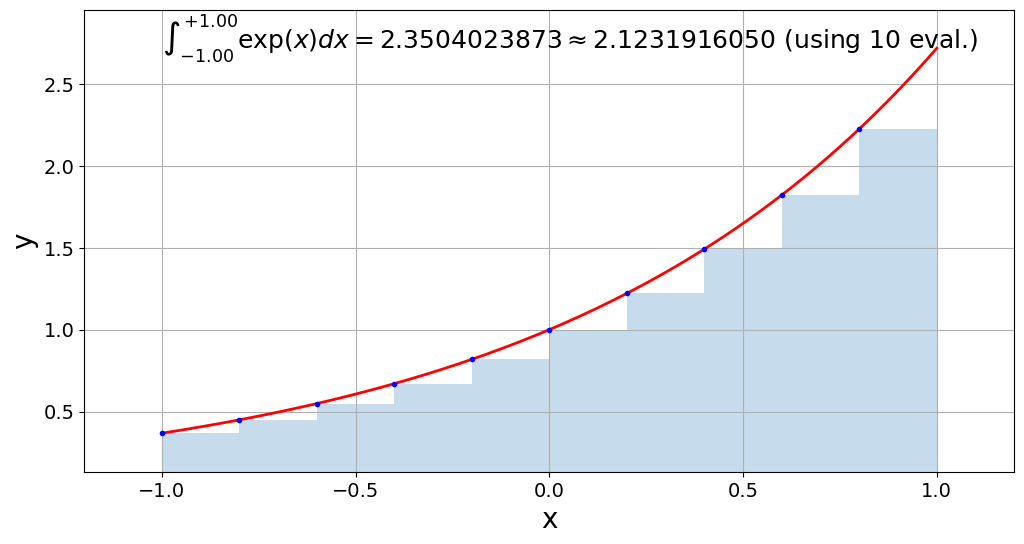

Approximated integral: 2.123191605036146


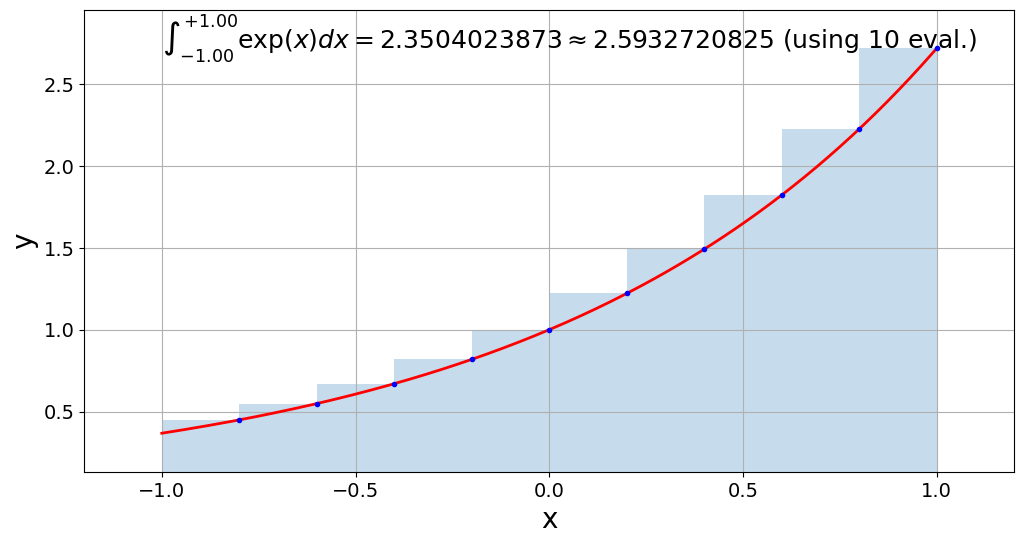

Approximated integral: 2.5932720824936664


In [4]:
###########################################################################
# Riemann Rule
###########################################################################
def riemann(myfun, m, a, b, direction='left', verbose=False, text=text, figname='', save_file=False):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, m+1) # We want m bins, so we need m+1 points  
    h = (b-a)/m
    if direction in 'left':
        xi = x[:-1]
    elif direction in 'right':
        xi = x[1:]
    else:
        print("Riemann Sum: You must choose direction='left' or direction='right'.")
        return
    w = np.full(m,h)
    int_val = np.dot(f(xi),w)
    if verbose:
        xbin = np.vstack([x[:-1], x[1:]]).flatten('F')
        ybin = np.vstack([f(xi), f(xi)]).flatten('F')
        plot(f, xbin, ybin, int_val, m, text, a, b, xi, figname, type_quadrature='riemann', save_file=save_file)
    return int_val

m=10
print('Approximated integral: {0}'.format(riemann(myfun, m, a, b, direction="left", 
                                    verbose=True, figname="riemann_left_%d.png"%m)))
print('Approximated integral: {0}'.format(riemann(myfun, m, a, b, direction="right", 
                                    verbose=True, figname="riemann_right_%d.png"%m)))

<div id='mp' />

## Midpoint Rule
[Back to TOC](#toc)

The _midpoint rule_ approximates the integral on the interval $[x_{k},x_{k+1}]$ as $f\left(\dfrac{x_k+x_{k+1}}{2}\right)\,h$.
One way to understand this method is by finding the best linear function within the interval $[x_k,x_{k+1}]$,
which end up being the line obtained by the Taylor approximation at the middle of the interval.
The composite version is as follows,
\begin{align*}
\int_{a}^{b} f(x) dx &= \sum_{i=1}^{m} \int_{x_{i-1}}^{x_{i}} f(x) dx  \\
                     &= \sum_{i=1}^{m} h\,f(\widehat{x}_i) + \underbrace{\frac{(b-a)}{24} h^2 f''(c)}_{\text{Error term}}
\end{align*}
where $h=(b-a)/m$, $\widehat{x}_i=\frac{1}{2}(x_{i-1}+x_{i})$ and $c\in[a,b]$.
One interesting feature of this method is that it does not require the evaluation of the function on the end points of the interval, which may be very useful in some cases.
The error term included gives us very useful information, it tells us that if $h$ is decreased in half, the error decreases by a factor of $4$.
This is very interesting! We say that the method is second order for this reason.

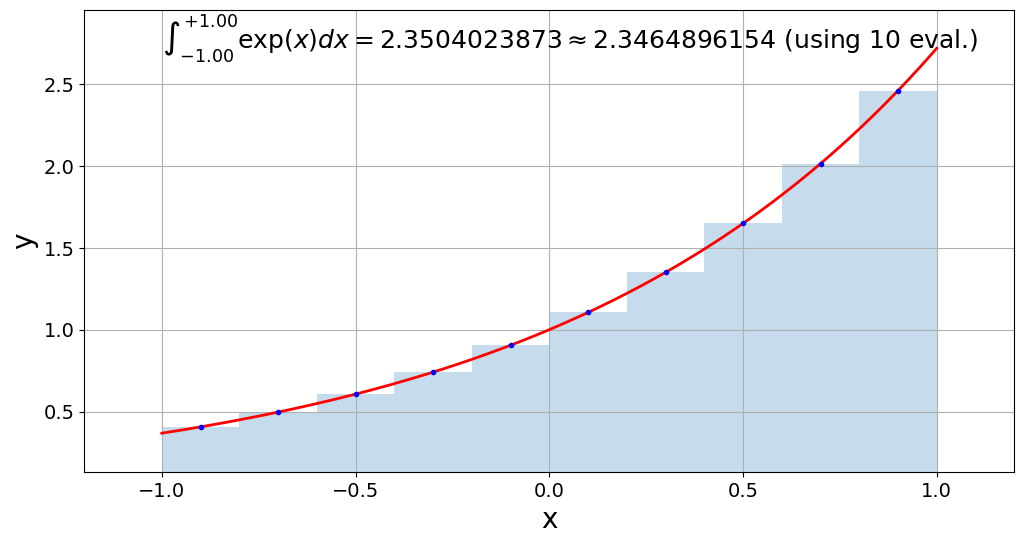

Approximated sum: 2.3464896153883052


In [5]:
def midpoint(myfun, m, a, b, verbose=False, text='', figname='', save_file=False):
    f = np.vectorize(myfun)
    x = np.linspace(a, b, m+1)
    h = (b-a)/m
    xhat = x[:-1] + h/2
    w = np.full(m,h)
    int_val = np.dot(f(xhat),w)
    if verbose:
        xbin = np.vstack([x[:-1], x[1:]]).flatten('F')
        ybin = np.vstack([f(xhat), f(xhat)]).flatten('F')
        plot(f, xbin, ybin, int_val, m, text, a, b, xhat, figname, type_quadrature='open', save_file=save_file)
    return int_val

m = 10
print('Approximated sum: {0}'.format(midpoint(myfun, m, a, b, 
    verbose=True, text=text, figname="midpoint_%d.png"%m)))

<div id='rt' />

## Trapezoid Rule
[Back to TOC](#toc)

This algorithm approximate the integral on interval $[x_k,x_{k+1}]$ by building a polynomial approximation on the interval, in particular uses a linear approximation.
The linear approximation is built with the points $(x_k,f(x_k))$ and $(x_{k+1},f(x_{k+1}))$.
The shape obtained is an actual trapezoid, thus is the reason for the name of the method.
In particular, the integral on the interval $[x_k,x_{k+1}]$ is approximated by $(f(x_k)+f(x_{k+1}))\,h/2$.
Now, the composite version becomes,
$$
\begin{align*}
\int_{x_0}^{x_m} f(x) dx &= \sum_{i=1}^{m} \int_{x_{i-1}}^{x_{i}} f(x) dx\\
                         &= \frac{h}{2}\left[f(a) + f(b) + 2\sum_{i=1}^{m-1} f(x_i) \right] - \underbrace{(b-a) \frac{h^2}{12} f''(c)}_{\text{Error term}}
\end{align*}
$$
where $h=(b-a)/m$ is the length of the sub-interval, and $c\in [a, b]$. 
In this case the error is also second order.

Notice that the error analysis shown before means the following:
$$
\begin{align*}
\left|\int_{a}^{b} f(x) dx 
-
\frac{h}{2}\left[f(a) + f(b) + 2\sum_{i=1}^{m-1} f(x_i) \right]
\right|
& =  |b-a| \frac{h^2}{12} \left|f''(c)\right| \leq |b-a| \frac{h^2}{12} \max_{y\in [a,b]}\left|f''(y)\right|
\end{align*}
$$
This has the following interpretations:
1. The trapezoidal rule will integrate exactly up to linear functions since they will have null second derivative.
2. If the hand bounded second derivative on the integration interval, this means $\displaystyle\max_{y\in [a,b]}\left|f''(y)\right|<\infty$, the method will converge cuadratically due to the $h^2$ term.
3. If the second derivative is not bounded on the interval, we may have issued of convergence. Recall that even if the second derivative is not bounded, the integral may still exists, the problem is that we may not be able to get it with all algorithms.
4. This analysis is valid for all algorithm, adapting it correspondingly to the error term they have.

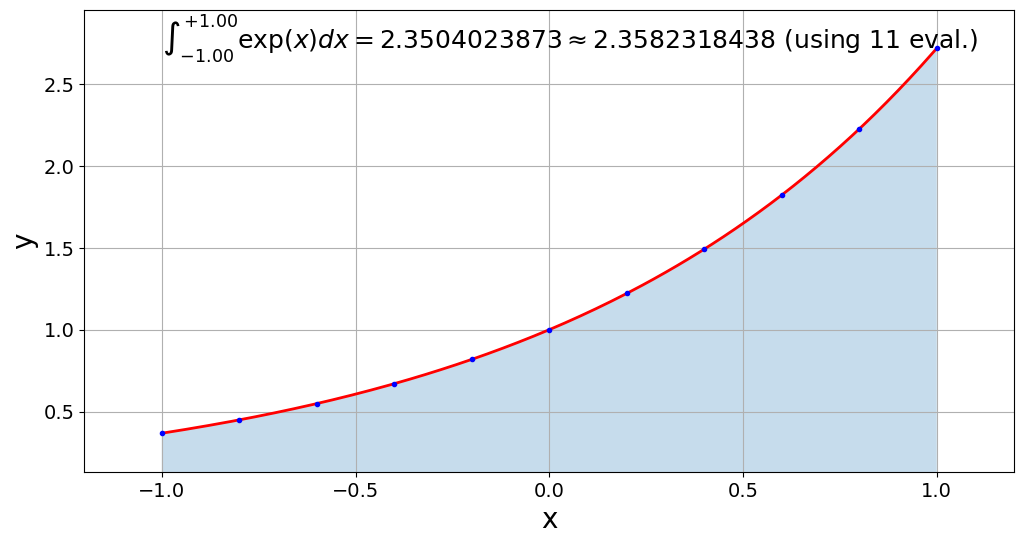

Approximated sum: 2.358231843764906


In [6]:
def trapezoid(myfun, m, a, b, verbose=False, text='', figname='', save_file=False):
    f = np.vectorize(myfun)
    xi = np.linspace(a, b, m+1)
    h = (b-a)/m
    w  = np.full(m+1,h)
    w[0] /=2
    w[-1] /=2
    int_val = np.dot(f(xi),w)
    if verbose:
        xbin = xi
        ybin = f(xi)
        plot(f, xbin, ybin, int_val, m, text, a, b, xi, figname, save_file=save_file)
    return int_val

m = 10
print('Approximated sum: {0}'.format(trapezoid(myfun, m, a, b, 
    verbose=True, text=text, figname="trapezoid_%d.png"%m)))

<div id='rs' />

## Simpson's Rule
[Back to TOC](#toc)

The natural extension of the Trapezoid rules is the Simpson's rule, which approximate the function $f(x)$ with three points, i.e. it builds a parabola and then it integrates it.
This the points used are $(x_k,f(x_k))$, $(x_{k+1},f(x_{k+1}))$ and $(x_{k+2},f(x_{k+2}))$.
For simplicity, we only provide the composite version, which is,
$$
\begin{align*}
\int_{a}^{b} f(x) dx &= \frac{h}{3} \left( f(x_0) + \sum_{i=1}^{n} 4 f(x_{2i-1}) + \sum_{i=1}^{n-1} 2 f(x_{2i}) +  f(x_{m}) \right) - \underbrace{(b-a)\frac{h^4}{90} f^{(4)}(c)}_{\text{Error term}}
\end{align*}
$$
where $h=(b-a)/m$ and $c\in[a,b]$.
In this, **it is required that $m$ is an even number**.
We also notice that the error has a higher order exponent of $h$, which is $h^4$, thus if we decrease $h$ by $2$, the the error decreases by $16$.
This is wonderful!

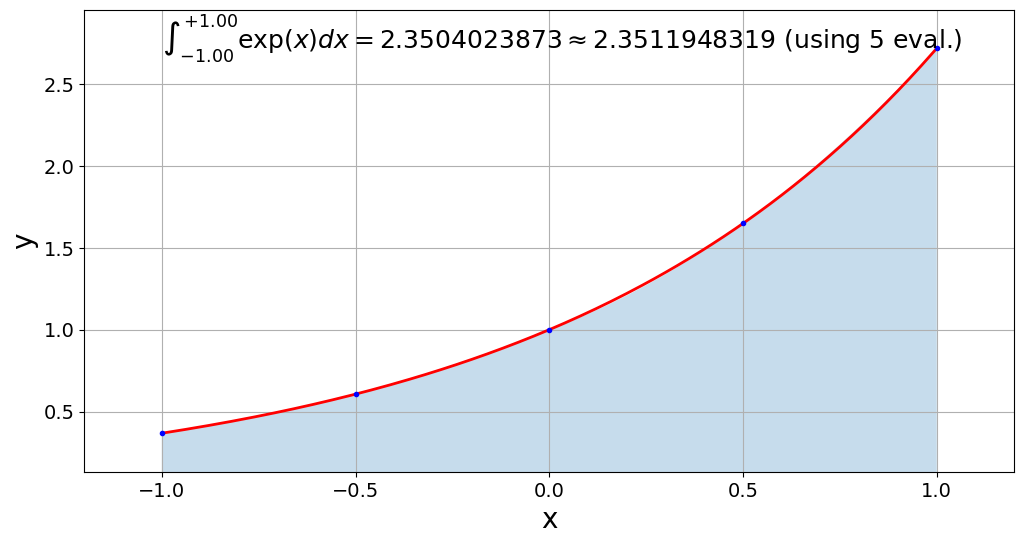

Approximated sum: 2.3511948318802554


In [7]:
def simpsons(myfun, m, a, b, verbose=False, text="", figname="", save_file=False):
    f = np.vectorize(myfun)
    xi = np.linspace(a, b, m+1)
    if m%2==1:
        if verbose: print("Simpson's rule is only applicable to an even number of segments.")
        return np.nan
    h = (b-a)/m
    w = np.full(m+1,h/3)
    w[1:-1:2]*=4
    w[2:-1:2]*=2
    int_val = np.dot(f(xi),w)
    if verbose:
        xbin, ybin = simpsons_bins(f, xi)
        plot(f, xbin, ybin, int_val, m, text, a, b, xi, figname, save_file=save_file)
    return int_val

def simpsons_bins(f, xg):
    xleft   = xg[:-2:2]
    xmiddle = xg[1::2]
    xright  = xg[2::2]
    xbin, ybin = [], []
    n = 21
    for x0, x1, x2 in zip(xleft, xmiddle, xright):
        xl = np.linspace(x0, x2, n)
        p = BarycentricInterpolator([x0,x1,x2],f([x0,x1,x2]))
        y = p(xl)
        xbin.extend(list(xl))
        ybin.extend(list(y))
    return np.array(xbin), np.array(ybin)

m=4
print('Approximated sum: {0}'.format(simpsons(myfun, m, a, b, 
    verbose=True, text=text, figname="simpsons_%d.png"%m)))

<div id='cg' />

## Gaussian Quadrature
[Back to TOC](#toc)

In a similar fashion used to introduce the Chebyshev points for polynomial interpolation, we have the followign question:

### _Would it possible to find really good nodes $x_k$ and weights $w_k$ for numerically integrate a funcion on $[a,b]$? Moreover, is it be possible to find nodes $x_k$ and weights $w_k$ for $k\in\{1,2,\dots,m\}$ such that we can integrate exactly polynomials of degree $2\,m-1$?_ 

The answer is yes! The points that define the nodes correspond to the roots of the Legendre polynomials $p_m(x)$, which is defined as follows:
\begin{align*}
    p_m(x) = \frac{1}{2^m m!} \frac{d^m}{dx^m} \left[ (x^2 - 1)^m \right].
\end{align*}
Given the $m$ nodes, we could build a polynomial interpolation of the function $f(x)$ at the nodes $x_i$, generating the polynomial $Q(x)=\sum_{i=1}^m L_i(x)\,f(x_i)$, where $L_i(x)$ is the Lagrange polynomial from the Lagrange interpolation. 
For simplicity, we will use the interval $[-1,1]$, thus,
\begin{align*}
    \int_{-1}^1 f(x)\,dx & \approx \int_{-1}^1 Q(x)\,dx\\
                         & \approx \int_{-1}^1 \sum_{i=1}^m L_i(x)\,f(x_i)\,dx\\
                         & \approx \sum_{i=1}^m f(x_i)\underbrace{\int_{-1}^1  L_i(x)\,dx}_{w_i}.
\end{align*}
Unfortunately this procedure is quite cumbersome for computing the nodes and weights of the Gaussian Quadrature.
So, what do we do then?
Fortunately we have a procedure ```gaussian_nodes_and_weights(m, a, b)``` that efficiently computes them! 
More details on this procedure are in the appendix of the classnotes.

In [8]:
# Comment: These nodes could be precomputed in advance, here
# they are computed as needed so it will penalize the 
# computation time.
def gaussian_nodes_and_weights(m, a, b):
    if m==1: 
        x=np.array([0.])
        w=np.array([2.])
    else:
        beta = .5 / np.sqrt(1.-(2.*np.arange(1.,m))**(-2))
        T = np.diag(beta,1) + np.diag(beta,-1)
        D, V = np.linalg.eigh(T)
        x = D
        w = 2*V[0,:]**2
    # Change of variable from [-1,1] to [a,b]
    x = .5 * ((b-a)*x + b + a)
    w = .5*(b-a)*w
    return x, w

# This procedure precomputed the Gaussian nodes and weights
# to be used in the 'gaussianquad' procedure.
gaussian_nodes_and_weights_precomputed_canonical={}
for i in range(1,101):
    x,w = gaussian_nodes_and_weights(i, -1, 1)
    gaussian_nodes_and_weights_precomputed_canonical[i]=(x,w)
for i in [216, 1024]:
    x,w = gaussian_nodes_and_weights(i, -1, 1)
    gaussian_nodes_and_weights_precomputed_canonical[i]=(x,w)

def gaussianquad(myfun, m, a, b, verbose=False, text="", figname="", save_file=False, use_precomputed_values=True):
    f = np.vectorize(myfun)
    if use_precomputed_values or m>100:
        xi, w = gaussian_nodes_and_weights(m, a, b)
    else:
        xi, w = gaussian_nodes_and_weights_precomputed_canonical[m]
        xi = .5 * ((b-a)*xi + b + a)
        w = .5*(b-a)*w
    int_val = np.dot(f(xi),w)
    if verbose:
        xbin, ybin = gaussian_bins(f, xi, w)
        plot(f, xbin, ybin, int_val, m, text, a, b, xi, figname, type_quadrature='open', save_file=save_file)
    return int_val

def gaussian_bins(f, x, w):
    z = [a] + list(a + w.cumsum())
    xbin = np.vstack([z[:-1], z[1:]]).flatten('F')
    z = f(x)
    ybin = np.vstack([z[:], z[:]]).flatten('F')
    return np.array(xbin), np.array(ybin)

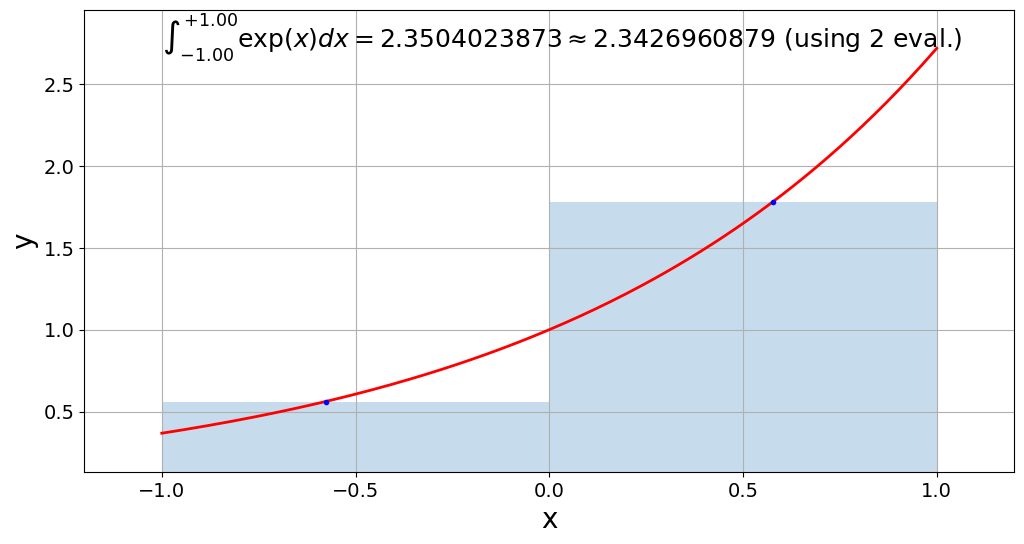

Approximated sum: 2.3426960879097303


In [9]:
m = 2
print('Approximated sum: {0}'.format(gaussianquad(myfun, m, a, b, verbose=True, 
                                    text=text, figname="gaussianquad_%d.png"%m)))

## Questions
- What is the computational importance of $h$ in the _Error term_ on each method?
- What is the computational importance of $f^{(k)}(c)$ in the _Error term_ on each method?

<div id='ca' />

# Convergence Analysis
[Back to TOC](#toc)

There exists two concepts highly related that we will use here, degree of precision and order of convergence, they will be defined now:

- **Degree of precision**: This correspond to the degree of the polynomials are integrated exactly by each method. For instance, for the _midpoint rule_ corresponds to $1$ since the second derivative of linear functions is equal to $0$.
- **Orden de convergencia**: The order of convergence, or just simple order, corresponds to the exponent of $h$ of the composite form of the error. For instance, the _midpoint rule_ is of second order, since the exponent of $h$ is $2$.

In the following examples we will analyze this numerically.

### Experiments

In [10]:
list_experiments=[]

###########################
# Function 1: exponential
# gaussian quad outperforms all the other methods
m_values = range(4, 11) #20
f = lambda x : np.exp(x)
a = -1.0
b = +2.0
sol = np.exp(b) - np.exp(a)
exp4 = (m_values, f, a, b, sol)
list_experiments.append(('exp1: '+inspect.getsource(f).replace('\n', ''),exp4))

###########################
# Function 2: Constant
# All methods are good
m_values = range(4, 11)
x0, x1, x2 = 5., -1., 3.
f = lambda x : 1
a = -1.0
b = +1.0
sol = 2
exp1 = (m_values, f, a, b, sol)
list_experiments.append(('exp2: '+inspect.getsource(f).replace('\n', ''),exp1))

###########################
# Function 3: sin
# All method equal if symmetric interval
# Gaussian quad better if asymmetric interval
m_values = range(4, 100)
f = lambda x : np.sin(x)
a = 0.0
b = +5.0
sol = -np.cos(b)+np.cos(a)
exp2 = (m_values, f, a, b, sol)
list_experiments.append(('exp3: '+inspect.getsource(f).replace('\n', ''),exp2))

###########################
# Function 4: gaussian bell
# gaussian quad outperforms all the other methods
m_values = range(4, 20)
f = lambda x : np.exp(-x**2)
a = -1.0
b = +1.0
sol = 1.4936482656248541 # Specific value for the range [-1,1]
exp3 = (m_values, f, a, b, sol)
list_experiments.append(('exp4: '+inspect.getsource(f).replace('\n', ''),exp3))

###########################
# Function 5: logarithm
m_values = range(4, 20)
f = lambda x : np.log(np.abs(x))
a = 1e-10 # 0
b = +1.0
sol = (b*np.log(b)-b) - (a*np.log(a)-a)#-2.0000000000000000 # -1 
exp5 = (m_values, f, a, b, sol)
list_experiments.append(('exp5: '+inspect.getsource(f).replace('\n', ''),exp5))

###########################
# Function 6 and true value
m_values = range(4, 20)
f = lambda x : np.sin(x)/x #if abs(x)>1e-6 else 1.0
a = -1.0
b = +1.0
sol = 1.8921661407343660
exp6 = (m_values, f, a, b, sol)
list_experiments.append(('exp6: '+inspect.getsource(f).replace('\n', ''),exp6))

###########################
# Function 7 : absolute value
# Midpoint wins
# Do (-1,1) and (-2,1)
m_values = range(4, 20)
f = lambda x : abs(x)
a = -1 #-np.pi
b = +1.0
sol = (a**2+b**2)/2.
exp7 = (m_values, f, a, b, sol)
list_experiments.append(('exp7: '+inspect.getsource(f).replace('\n', ''),exp7))

###########################
# Function 8 : Gaussian
# Midpoint/Traps wins over gaussian
m_values = range(4, 100)
f = lambda x : np.exp(-x**2)
a = -10.0
b = +10.0
sol = np.sqrt(math.pi)
exp8 = (m_values, f, a, b, sol)
list_experiments.append(('exp8: '+inspect.getsource(f).replace('\n', ''),exp8))

###########################
# Function 9 : 1/x^2
# Gaussian wins, but they all degrade if a->0
# Here we should try an adaptative method
m_values = range(4, 20)
f = lambda x : 1.0/(x**2)
a = 1e-4
b = +1.
sol = 1.0/a - 1.0/b
exp9 = (m_values, f, a, b, sol)
list_experiments.append(('exp9: '+inspect.getsource(f).replace('\n', ''),exp9))

###########################
# Function 10 : 1/x^0.5
m_values = range(4, 20)
f = lambda x : 1.0/(np.sqrt(np.abs(x)))
a = 0.0
b = 1.0
sol = 2.0
exp10 = (m_values, f, a, b, sol)
list_experiments.append(('exp10: '+inspect.getsource(f).replace('\n', ''),exp10))

## Code for performing convergence analysis

In [11]:
def get_error_and_time(quadrature_rule, myfun, m_range, a, b, true_value, get_time=False, direction_riemann='left'):
    quad_error = []
    if get_time:
        quad_times = []
        m_range = np.logspace(1, 10, num=5, endpoint=True, base=2, dtype=int)
        for i in range(len(m_range)):
            if m_range[i]%2==1:
                m_range[i]+=1
        for m in m_range:
            if quadrature_rule==riemann:
                error = np.abs(true_value - quadrature_rule(myfun, m, a, b, direction=direction_riemann))
            else:
                error = np.abs(true_value - quadrature_rule(myfun, m, a, b))
            if error<1e-16:
                quad_error.append(1E-16)
            else:
                quad_error.append(error)
            if quadrature_rule==riemann:
                out = %timeit -o -q -n 10 -r 5 quadrature_rule(myfun, m, a, b, direction=direction_riemann)
            else:
                out = %timeit -o -q -n 10 -r 5 quadrature_rule(myfun, m, a, b)
            quad_times.append(out.average)
        return quad_error, quad_times, m_range
    else: 
        for m in m_range:
            if quadrature_rule==riemann:
                error = np.abs(true_value - quadrature_rule(myfun, m, a, b, direction=direction_riemann))
            else:
                error = np.abs(true_value - quadrature_rule(myfun, m, a, b))
            if error<1e-16:
                quad_error.append(1E-16)
            else:
                quad_error.append(error)
        return quad_error

def set_ylim(ymin, ymax):
    ymin = min(plt.ylim()[0], ymin)
    ymax = max(plt.ylim()[1], ymax)
    plt.ylim([ymin, ymax])
    return

def convergence(exp_data):
    m_range     = exp_data[0]
    myfun      = exp_data[1]
    a          = exp_data[2]
    b          = exp_data[3]
    true_value = exp_data[4]
    #######################################################
    print('Printing numerical experiment details:')
    print('m_range: ', m_range)
    print(inspect.getsource(myfun).replace('\n', ''))
    print('a: ', a)
    print('b: ', b)
    print('true_value: ', true_value)
    #######################################################
    ms = 10
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    e_rl = get_error_and_time(riemann, myfun, m_range, a, b, true_value)
    e_rr = get_error_and_time(riemann, myfun, m_range, a, b, true_value, direction_riemann='right')
    e_mp = get_error_and_time(midpoint, myfun, m_range, a, b, true_value)
    e_tr = get_error_and_time(trapezoid, myfun, m_range, a, b, true_value)
    e_sp = get_error_and_time(simpsons, myfun, m_range, a, b, true_value)
    e_gq = get_error_and_time(gaussianquad, myfun, m_range, a, b, true_value)

    fig = plt.figure(figsize=(16,16))
    plt.rcParams.update({'font.size': 22})
    
    # First plot
    ax = plt.subplot(2,2,1)
    dd = 0.1*(b-a)
    x = np.linspace(a-dd, b+dd, 1000)
    plt.plot(x, f(x), 'k', label="f(x)", lw=2.0)
    x = np.linspace(a, b, 1000)
    plt.fill_between(x, f(x), 0, alpha=0.5, label=r"$\int_a^b f(x) dx$")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    ymax = 1.05*plt.ylim()[1]
    plt.ylim([-ymax, ymax])
    plt.grid('on')
    plt.legend(loc="lower left")
    
    # Second plot
    ax = plt.subplot(2,2,2) 
    plt.plot(m_range, e_rl, 'Pm', lw=2.0, ms=ms, label="Riemann Left")
    plt.plot(m_range, e_rr, 'hc', lw=2.0, ms=ms, label="Riemann Right")
    plt.plot(m_range, e_mp, 'sb', lw=2.0, ms=ms, label="Midpoint")
    plt.plot(m_range, e_tr, 'or', lw=2.0, ms=ms, label="Trapezoid")
    plt.plot(m_range, e_sp, '>y', lw=2.0, ms=ms, label="Simpsons")
    plt.plot(m_range, e_gq, 'Dg', lw=2.0, ms=ms, label="Gaussian Quad")
    set_ylim(-5E-2, 1E-1)
    plt.xlabel("m")
    plt.ylabel("Absolute Error")
    #ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1.00), ncol=1, fancybox=True, shadow=True, numpoints=1)
    ##ax.legend(loc='upper right', ncol=1, fancybox=True, shadow=True, numpoints=1)
    ax.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    plt.grid('on')
    
    # Third plot
    ax = plt.subplot(2,2,3)
    plt.loglog(m_range, e_rl, 'Pm', lw=2.0, ms=ms, label="Riemann Left")
    plt.loglog(m_range, e_rr, 'hc', lw=2.0, ms=ms, label="Riemann Right")
    plt.loglog(m_range, e_mp, 'sb', ms=ms, lw=2.0, label="Midpoint")
    plt.loglog(m_range, e_tr, 'or', ms=ms, lw=2.0, label="Trapezoid")
    plt.loglog(m_range, e_sp, '>y', ms=ms, lw=2.0, label="Simpsons")
    plt.loglog(m_range, e_gq, 'Dg', ms=ms, lw=2.0, label="Gaussian Quad")
    #ax.legend(loc='best', ncol=1, fancybox=True, shadow=True, numpoints=1)
    plt.ylim([1E-18, 1E+1])
    '''m = np.arange(1,101,10)
    plt.loglog(m, 1./m**2, '-k', lw=2.0, alpha=0.5)
    plt.loglog(m, 1./m**4, '-k', lw=2.0, alpha=0.5)'''
    plt.xlabel("m")
    plt.ylabel("Absolute Error")
    plt.xlim([0.9*min(m_range),1.1*max(m_range)])
    plt.grid('on')
    
    # Forth plot
    ax = plt.subplot(2,2,4)
    h = 1./np.arange(1,101,10)
    plt.loglog(h, h, '-k', lw=2.0, alpha=0.5, label=r'$O(h)$')
    plt.loglog(h, h**2, '--k', lw=2.0, alpha=0.5, label=r'$O(h^2)$')
    plt.loglog(h, h**3, '-.k', lw=2.0, alpha=0.5, label=r'$O(h^3)$')
    plt.loglog(h, h**4, 'k', linestyle='dotted', lw=2.0, alpha=0.5, label=r'$O(h^4)$')
    # Plotting Gaussian Quadratupre first but using larger markers
    h = 1./np.array(m_range)
    plt.loglog(h, e_rl, 'Pm', lw=2.0, ms=ms, label="Riemann Left")
    plt.loglog(h, e_rr, 'hc', lw=2.0, ms=ms, label="Riemann Right")
    plt.loglog(h, e_mp, 'sb', lw=2.0, ms=ms, label="Midpoint")
    plt.loglog(h, e_tr, 'or', lw=2.0, ms=ms, label="Trapezoid")
    plt.loglog(h, e_sp, '>y', lw=2.0, ms=ms, label="Simpsons")
    plt.loglog(h, e_gq, 'Dg', lw=2.0, ms=ms, label="Gaussian Quad")
    ax.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    plt.ylim([1e-18, 1e+1])
    plt.xlabel("h")
    plt.ylabel("Absolute Error")
    plt.grid('on')
    plt.xlim([0.9*min(h),1.1*max(h)])
    plt.show()
    #fig.savefig('myfig.eps', format='eps')
    
    ##########################################
    # Showing output of last plot in a Table.
    ##########################################
    # This table shows on each column the 'error' achieved by each method for the 
    # corresponding (m,h) tuple in log scale, notice that 'm' corresponds to the number
    # intervals used in the numerical integration and 'h' the corresponding length of each interval. 
    # The value showed on each row corresponds to each different algorithm.
    data = np.zeros((6,len(m_range)))
    data[0,:] = e_rl
    data[1,:] = e_rr
    data[2,:] = e_mp
    data[3,:] = e_tr
    data[4,:] = e_sp
    data[5,:] = e_gq
    data      = np.log10(data)
    columns    = list(zip(m_range,np.round(np.log10(h),3)))
    rows      = ['Riemann Left', 'Riemann Right', 'Midpoint', 'Trapezoid', 'Simpsons', 'Gaussian Quad']
    df = pd.DataFrame(data=data, index=rows, columns=columns)
    display(df)

### Convergence test

In [12]:
interact(convergence, exp_data=list_experiments)

interactive(children=(Dropdown(description='exp_data', options=(('exp1: f = lambda x : np.exp(x)', (range(4, 1…

<function __main__.convergence(exp_data)>

<div id='ta' />

# Time Analysis
[Back to TOC](#toc)

In [13]:
def timing(exp_data):
    m_range     = exp_data[0]
    myfun      = exp_data[1]
    a          = exp_data[2]
    b          = exp_data[3]
    true_value = exp_data[4]
    #######################################################
    print('Printing numerical experiment details:')
    print('m_range: logarithmic range used')
    print(inspect.getsource(myfun).replace('\n', ''))
    print('a: ', a)
    print('b: ', b)
    print('true_value: ', true_value)
    #######################################################
    ms = 10
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    e_rl, t_rl, _ = get_error_and_time(riemann, myfun, m_range, a, b, true_value, get_time=True)
    e_rr, t_rr, _ = get_error_and_time(riemann, myfun, m_range, a, b, true_value, get_time=True, direction_riemann='right')
    e_mp, t_mp, _ = get_error_and_time(midpoint, myfun, m_range, a, b, true_value, get_time=True)
    e_tr, t_tr, _ = get_error_and_time(trapezoid, myfun, m_range, a, b, true_value, get_time=True)
    e_sp, t_sp, _ = get_error_and_time(simpsons, myfun, m_range, a, b, true_value, get_time=True)
    e_gq, t_gq, m_range = get_error_and_time(gaussianquad, myfun, m_range, a, b, true_value, get_time=True)

    fig = plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 10})
        
    # Plotting Gaussian Quadratupre first but using larger markers
    plt.loglog(e_rl, t_rl, 'Pm', lw=2.0, ms=ms, label="Riemann Left")
    plt.loglog(e_rr, t_rr, 'hc', lw=2.0, ms=ms, label="Riemann Right")
    plt.loglog(e_mp, t_mp, 'sb', lw=2.0, ms=ms, label="Midpoint")
    plt.loglog(e_tr, t_tr, 'or', lw=2.0, ms=ms, label="Trapezoid")
    plt.loglog(e_sp, t_sp, '>y', lw=2.0, ms=ms, label="Simpsons")
    plt.loglog(e_gq, t_gq, 'Dg', lw=2.0, ms=ms, label="Gaussian Quad")
    #plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True, numpoints=1)
    plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    plt.xlabel("Absolute Error")
    plt.ylabel("Time in seconds")
    plt.grid('on')
    plt.show()
    #fig.savefig('myfig.eps', format='eps')
    
    ############################
    # Showing output in a Table.
    ############################
    # This table show on each columns the tuple (error,computation time in seconds) in log10 scale 
    # achieved by each method for the corresponding (m,h) tuple used, notice that 'm' corresponds to the number
    # intervals used in the numerical integration and 'h' the corresponding length of each interval. 
    # The value showed on each row corresponds to each different algorithm.
    # What we expect from this table is to get the lowest error possible in the lowest time possible,
    # since the values are shown in log10 scale, this means that the lowest values will be the 
    # most negative values. Read the table carefully, it is challenging to undestanding it but
    # very important.
    h = (b-a)/m_range
    data = list()
    for e_alg, t_alg in zip([e_rl, e_rr, e_mp, e_tr, e_sp, e_gq],[t_rl, t_rr, t_mp, t_tr, t_sp, t_gq]):
        data.append(list(zip(np.round(np.log10(e_alg),3),np.round(np.log10(t_alg),3))))
    columns   = list(zip(m_range,np.round(np.log10(h),3)))
    rows      = ['Riemann Left', 'Riemann Right', 'Midpoint', 'Trapezoid', 'Simpsons', 'Gaussian Quad']
    df = pd.DataFrame(data=data, index=rows, columns=columns)
    display(df)

### Time test

In [ ]:
interact(timing, exp_data=list_experiments)

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* **DISCLAIMER**: El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín Villanueva. DI UTFSM. Abril 2016._
* [Update 2016] (Martín) Notebook creado como una fusión de las tres partes anteriores. Modificadas funciones de integración con parámetro verbose para controlar la salida, y añadido el decorador para medir los tiempos. 
* [Update 2017] (Cristopher) Corrección de typos, correccion de método del trapecio.
* [Update 2017] (C. Torres) Adding *interact*.
* [Update 2019] (C. Torres) changing .flatten(1) to .flatten('F'). Fixing issue with titles of sections.
* _Update June 2021 - v1.24 - C.Torres_ : Adding TOC link, translating to English, timing computation update, and major update in general.
* _Update June 2021 - v1.25 - C.Torres_ : Fixing issue with the number of evaluations of a Riemann sum. Adding flag for last cell of notebook.
* _Update June 2021 - v1.26 - C.Torres_ : Adding Riemann Sum by left and right to convergence and time analysis. Adding Table to show output of the convergence analysis and time analysis. Updating explanation generated in class for the Trapezoidal quadrature.
* _Update June 2022 - v1.27 - C.Torres_ : Adding Markdown support for formulas with \$\$.
* _Update June 2024 - v1.28 - Felipe Fuentes Villegas_ : Fixing type in the use of indices for the Simpson's method.
* _Update March 2025 - v1.29 - C.Torres_ : Moved to new github repo, fixing an issue with the local ``plot``function and changing file name.
* _Update March 2025 - v1.30 - C.Torres_ : Adding Colab link.
* _Update June 2025 - v1.31 - C.Torres_ : Fixing bug in Gaussian quadrature for m=1 and adding blue dots (f(xi)) in the plots.

# Appendix used to compute the plots for the classnotes.
[Back to TOC](#toc)

In [ ]:
FLAG_generate_images = False
FLAG_save_file = False
if FLAG_generate_images:
    a, b = -1, 1
    myfun = lambda x : np.exp(x)
    m_values = np.power(2,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int)
    #text to show in the graphs
    # Notice that in thios case we know the exact value of the integral,
    # this is why we are adding explicitly. But in general we don't know it!
    text= r"\int_{-1}^{1} \exp(x) dx = %.10f " %(np.exp(1)-np.exp(-1))
    for m in m_values:
        riemann(myfun, m, a, b, direction="left", verbose=True, 
                      text=text, figname="classnotes_riemann_left_%d.png"%m, save_file=FLAG_save_file)
        riemann(myfun, m, a, b, direction="right", verbose=True,
                      text=text, figname="classnotes_riemann_right_%d.png"%m,save_file=FLAG_save_file)
        midpoint(myfun, m, a, b, verbose=True, text=text, figname="classnotes_midpoint_%d.png"%m,save_file=FLAG_save_file)
        trapezoid(myfun, m, a, b, verbose=True,
                        text=text, figname="classnotes_trapezoid_%d.png"%m,save_file=FLAG_save_file)
        simpsons(myfun, m, a, b, verbose=True,
                       text=text, figname="classnotes_simpsons_%d.png"%m,save_file=FLAG_save_file)
        gaussianquad(myfun, m, a, b, verbose=True,
                           text=text, figname="classnotes_gaussianquad_%d.png"%m,save_file=FLAG_save_file)